In [1]:
# ================================
# BYOL Step 1: Imports
# ================================
import os, math, time, warnings
from pathlib import Path

import random   
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms as T, models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import plotly.express as px

from contextlib import nullcontext
from torch.amp import GradScaler, autocast  # modern API


In [2]:
# ============================
# BYOL Step 2: Config & Paths 
# ============================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# CSVs are inside EuroSAT folder 
CSV_ROOT = "/kaggle/input/eurosat-dataset/EuroSAT"
IMG_ROOT = "/kaggle/input/eurosat-dataset/EuroSAT"

TRAIN_CSV = "train.csv"
VAL_CSV   = "validation.csv"
TEST_CSV  = "test.csv"

IMG_SIZE = 224
BATCH_SIZE_PRETRAIN = 64
EPOCHS_PRETRAIN = 500
LR_PRETRAIN = 3e-4
PROJ_DIM = 128

BATCH_SIZE_LINEAR = 64
EPOCHS_LINEAR = 500
LR_LINEAR = 1e-3

print("Device:", DEVICE)
print(f"Device: {DEVICE.type}")
print(f"IMG_ROOT: {IMG_ROOT}")
print(f"CSV_ROOT: {CSV_ROOT}")
print(f"Splits: {TRAIN_CSV} {VAL_CSV} {TEST_CSV}")


Device: cuda
Device: cuda
IMG_ROOT: /kaggle/input/eurosat-dataset/EuroSAT
CSV_ROOT: /kaggle/input/eurosat-dataset/EuroSAT
Splits: train.csv validation.csv test.csv


In [3]:
# =========================
# BYOL Step 3: CSV Loading 
# =========================
def _pick_col(df, candidates):
    lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in df.columns: return cand
        if cand.lower() in lower: return lower[cand.lower()]
    return None

def _fix_one_path(p: str, img_root: str):
    p = str(p).strip()
    if os.path.exists(p): return p
    cand = os.path.join(img_root, p.lstrip("/"))
    if os.path.exists(cand): return cand
    if p.startswith("/kaggle/input/"):
        parts = p.split("/")
        try:
            newp = os.path.join(img_root, "/".join(parts[4:]))
            if os.path.exists(newp): return newp
        except Exception:
            pass
    return cand

def _infer_path_from_parts(row, img_root, filename_col=None, class_col=None):
    fname = str(row[filename_col]).strip() if filename_col else None
    cname = str(row[class_col]).strip() if class_col else None
    cands = []
    if fname:
        cands.append(os.path.join(img_root, fname))
        if class_col:
            cands.append(os.path.join(img_root, cname, fname))
            cands.append(os.path.join(img_root, cname.lower(), fname))
            cands.append(os.path.join(img_root, cname.capitalize(), fname))
    for c in cands:
        if os.path.exists(c): return c
    return cands[0] if cands else None

def load_split(csv_root: str, csv_name: str, img_root: str):
    csv_path = os.path.join(csv_root, csv_name)
    df = pd.read_csv(csv_path)

    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    path_col     = _pick_col(df, ["path", "filepath", "image", "image_path", "file"])
    filename_col = _pick_col(df, ["filename", "file_name", "image_id"])
    class_col    = _pick_col(df, ["classname", "class_name", "class", "category"])
    label_col    = _pick_col(df, ["label", "labels", "target", "y", "Label"])

    if path_col:
        df["path_fixed"] = df[path_col].apply(lambda p: _fix_one_path(p, img_root))
    elif filename_col:
        df["path_fixed"] = df.apply(lambda r: _infer_path_from_parts(r, img_root, filename_col, class_col), axis=1)
    else:
        raise ValueError(f"No path-like column found. Available: {list(df.columns)}.")

    if label_col is not None:
        if np.issubdtype(df[label_col].dtype, np.number):
            df["label_fixed"] = df[label_col].astype(int)
        else:
            df["label_fixed"] = pd.Categorical(df[label_col]).codes
    elif class_col is not None:
        df["label_fixed"] = pd.Categorical(df[class_col]).codes
    else:
        raise ValueError(f"No label-like column found. Available: {list(df.columns)}.")

    out = df[["path_fixed", "label_fixed"]].rename(columns={"path_fixed":"path","label_fixed":"label"})
    print(out.head())
    return out

# Load with corrected roots
train_df = load_split(CSV_ROOT, TRAIN_CSV, IMG_ROOT)
val_df   = load_split(CSV_ROOT, VAL_CSV,   IMG_ROOT)
test_df  = load_split(CSV_ROOT, TEST_CSV,  IMG_ROOT)

num_classes = int(max(train_df["label"].max(), val_df["label"].max(), test_df["label"].max()) + 1)
print(f"Loaded splits — train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}, classes: {num_classes}")


                                                path  label
0  /kaggle/input/eurosat-dataset/EuroSAT/AnnualCr...      0
1  /kaggle/input/eurosat-dataset/EuroSAT/Herbaceo...      2
2  /kaggle/input/eurosat-dataset/EuroSAT/Permanen...      6
3  /kaggle/input/eurosat-dataset/EuroSAT/Industri...      4
4  /kaggle/input/eurosat-dataset/EuroSAT/Herbaceo...      2
                                                path  label
0  /kaggle/input/eurosat-dataset/EuroSAT/Pasture/...      5
1  /kaggle/input/eurosat-dataset/EuroSAT/Forest/F...      1
2  /kaggle/input/eurosat-dataset/EuroSAT/Highway/...      3
3  /kaggle/input/eurosat-dataset/EuroSAT/River/Ri...      8
4  /kaggle/input/eurosat-dataset/EuroSAT/SeaLake/...      9
                                                path  label
0  /kaggle/input/eurosat-dataset/EuroSAT/AnnualCr...      0
1  /kaggle/input/eurosat-dataset/EuroSAT/Resident...      7
2  /kaggle/input/eurosat-dataset/EuroSAT/Pasture/...      5
3  /kaggle/input/eurosat-dataset/EuroSAT


Train per-class counts (label -> count)
0: 2100
1: 2100
2: 2100
3: 1750
4: 1750
5: 1400
6: 1750
7: 2100
8: 1750
9: 2100


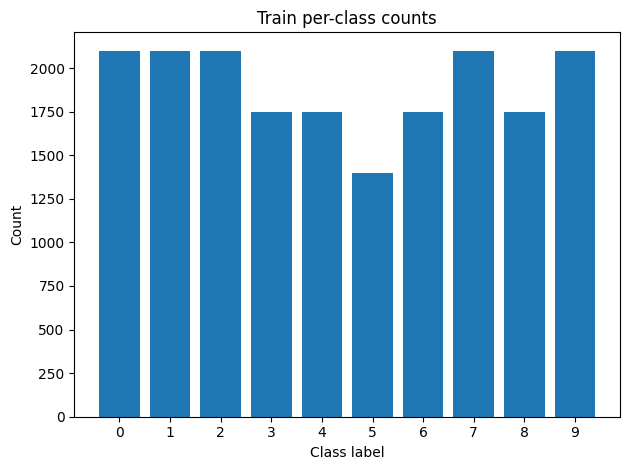


Val per-class counts (label -> count)
0: 600
1: 600
2: 600
3: 500
4: 500
5: 400
6: 500
7: 600
8: 500
9: 600


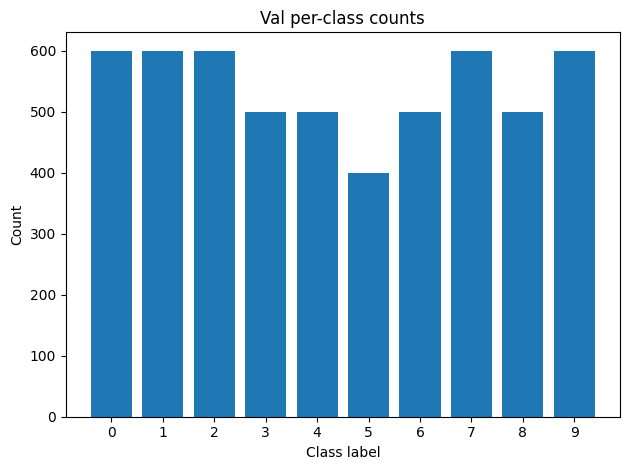


Test per-class counts (label -> count)
0: 300
1: 300
2: 300
3: 250
4: 250
5: 200
6: 250
7: 300
8: 250
9: 300


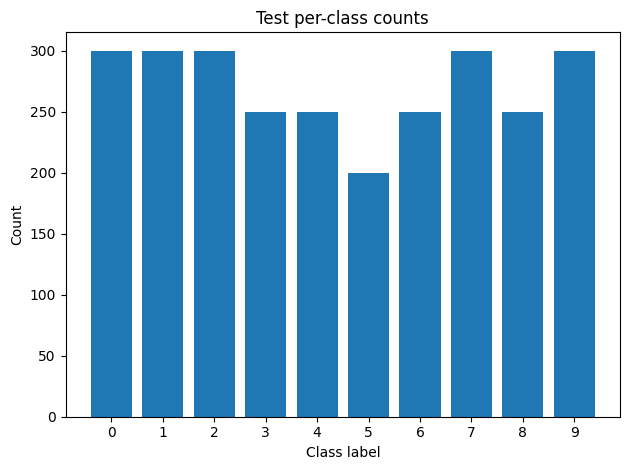

In [4]:
# ========================================
# BYOL Step 4: Per-class image count plots
# ========================================
def _counts_bar(vc, title):
    plt.figure()
    xs = list(range(len(vc.index)))
    ys = [int(v) for v in vc.values]
    plt.bar(xs, ys)
    plt.xticks(xs, [str(i) for i in vc.index], rotation=0)
    plt.title(title)
    plt.xlabel("Class label")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def show_split_counts(train_df, val_df, test_df):
    for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        vc = df["label"].value_counts().sort_index()
        print(f"\n{name} per-class counts (label -> count)")
        for k, v in vc.items():
            print(f"{k}: {v}")
        _counts_bar(vc, f"{name} per-class counts")

show_split_counts(train_df, val_df, test_df)


In [5]:
# --- Augmentations for BYOL (two views of the same image) ---
class TransformBYOL:
    def __init__(self, size=IMG_SIZE):
        self.base = T.Compose([
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply([T.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.5),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    def __call__(self, x):
        # two independently augmented views
        q = self.base(x)
        k = self.base(x)
        return q, k

# Single-view transform (for linear eval features/classification)
class SingleTransform:
    def __init__(self, size=IMG_SIZE):
        self.t = T.Compose([
            T.Resize(int(size*1.14)),
            T.CenterCrop(size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])
    def __call__(self, x):
        return self.t(x)

# --- Datasets ---
class PairDataset(torch.utils.data.Dataset):
    """Returns two augmented views of the same image (BYOL pretraining)."""
    def __init__(self, df, transform_pair: TransformBYOL):
        self.df = df.reset_index(drop=True)
        self.transform_pair = transform_pair

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        p = self.df.loc[idx, "path"]
        img = Image.open(p).convert("RGB")
        v1, v2 = self.transform_pair(img)
        return v1, v2

class ClassifyDataset(torch.utils.data.Dataset):
    """Single view + label (for linear eval)."""
    def __init__(self, df, transform: SingleTransform):
        self.df = df.reset_index(drop=True)
        self.t = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        p  = self.df.loc[idx, "path"]
        y  = int(self.df.loc[idx, "label"])
        img = Image.open(p).convert("RGB")
        x = self.t(img)
        return x, y

In [6]:
# ===================================
# BYOL Step 6: Dataloaders (Optimized)
# ===================================
pair_tf   = TransformBYOL(IMG_SIZE)
single_tf = SingleTransform(IMG_SIZE)

train_pair_ds = PairDataset(train_df, pair_tf)
val_pair_ds   = PairDataset(val_df,   pair_tf)

train_pair_loader = DataLoader(
    train_pair_ds,
    batch_size=BATCH_SIZE_PRETRAIN,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,
    prefetch_factor=4
)

val_pair_loader = DataLoader(
    val_pair_ds,
    batch_size=BATCH_SIZE_PRETRAIN,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,
    prefetch_factor=4
)

train_cls_ds = ClassifyDataset(train_df, single_tf)
val_cls_ds   = ClassifyDataset(val_df,   single_tf)
test_cls_ds  = ClassifyDataset(test_df,  single_tf)

train_cls_loader = DataLoader(
    train_cls_ds,
    batch_size=BATCH_SIZE_LINEAR,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)

val_cls_loader = DataLoader(
    val_cls_ds,
    batch_size=BATCH_SIZE_LINEAR,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)

test_cls_loader = DataLoader(
    test_cls_ds,
    batch_size=BATCH_SIZE_LINEAR,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)

print("PairDataset length:", len(train_pair_ds))
print("ClassifyDataset length:", len(train_cls_ds))


PairDataset length: 18900
ClassifyDataset length: 18900


In [7]:
# =================================================================
# BYOL Step 7: Model (Encoder + Projection/Prediction + Target EMA)
# =================================================================
from copy import deepcopy

# --- Encoder (ResNet-50 backbone without final FC) ---
def build_encoder(pretrained: bool = False):
    enc = models.resnet50(weights=None if not pretrained else models.ResNet50_Weights.IMAGENET1K_V2)
    feat_dim = enc.fc.in_features
    enc.fc = nn.Identity()
    return enc, feat_dim

# --- Small helpers ---
class L2Norm(nn.Module):
    def __init__(self, dim=1, eps=1e-8):
        super().__init__()
        self.dim = dim
        self.eps = eps
    def forward(self, x):
        return F.normalize(x, dim=self.dim, eps=self.eps)

# --- Projection MLP (BYOL) ---
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=PROJ_DIM, hidden_dim=None):
        super().__init__()
        h = hidden_dim or in_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, h, bias=False),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, proj_dim, bias=False),
            nn.BatchNorm1d(proj_dim, affine=False),  
        )
        self.norm = L2Norm(dim=1)
    def forward(self, x):
        z = self.net(x)
        return self.norm(z)

# --- Prediction MLP (BYOL) ---
class PredictionHead(nn.Module):
    def __init__(self, in_dim=PROJ_DIM, hidden_dim=None, out_dim=PROJ_DIM):
        super().__init__()
        h = hidden_dim or max(128, in_dim // 2)
        self.net = nn.Sequential(
            nn.Linear(in_dim, h, bias=False),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim)
        )
        self.norm = L2Norm(dim=1)
    def forward(self, z):
        p = self.net(z)
        return self.norm(p)

# --- BYOL Online / Target Wrappers ---
class OnlineNet(nn.Module):
    def __init__(self, encoder, feat_dim, proj_dim=PROJ_DIM):
        super().__init__()
        self.encoder = encoder
        self.projector = ProjectionHead(feat_dim, proj_dim=proj_dim)
        self.predictor = PredictionHead(in_dim=proj_dim, out_dim=proj_dim)
    def forward(self, x):
        h = self.encoder(x)           # [B, feat_dim]
        z = self.projector(h)         # [B, proj_dim] (normalized)
        p = self.predictor(z)         # [B, proj_dim] (normalized)
        return p, z

class TargetNet(nn.Module):
    def __init__(self, encoder, feat_dim, proj_dim=PROJ_DIM):
        super().__init__()
        self.encoder = encoder
        self.projector = ProjectionHead(feat_dim, proj_dim=proj_dim)
        # target has no predictor; it supplies stop-grad "z"
        for p in self.parameters():
            p.requires_grad = False
    @torch.no_grad()
    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z

# --- EMA utilities ---
@torch.no_grad()
def copy_params(src: nn.Module, dst: nn.Module):
    for p_s, p_d in zip(src.parameters(), dst.parameters()):
        p_d.data.copy_(p_s.data)

@torch.no_grad()
def momentum_update(target: nn.Module, online: nn.Module, m: float = 0.996):
    for p_t, p_o in zip(target.parameters(), online.parameters()):
        p_t.data = p_t.data * m + p_o.data * (1.0 - m)

# --- BYOL loss (symmetric cosine) ---
def byol_loss(p, z):
    # p, z are L2-normalized; stop-grad should be applied to z before calling this
    return 2 - 2 * F.cosine_similarity(p, z, dim=1).mean()

# --- Full BYOL module (manages online/target, forward computes loss) ---
class BYOL(nn.Module):
    def __init__(self, proj_dim=PROJ_DIM, momentum=0.996, pretrained_backbone=False):
        super().__init__()
        self.m = momentum

        # build online & target encoders
        enc_online, feat_dim = build_encoder(pretrained=pretrained_backbone)
        enc_target, _        = build_encoder(pretrained=pretrained_backbone)

        self.online  = OnlineNet(enc_online, feat_dim, proj_dim=proj_dim)
        self.target  = TargetNet(enc_target, feat_dim, proj_dim=proj_dim)

        # init target = online
        copy_params(self.online.encoder,   self.target.encoder)
        copy_params(self.online.projector, self.target.projector)

    @torch.no_grad()
    def update_target(self):
        momentum_update(self.target.encoder,   self.online.encoder,   m=self.m)
        momentum_update(self.target.projector, self.online.projector, m=self.m)

    def forward(self, x1, x2):
        # online predictions
        p1, z1_online = self.online(x1)
        p2, z2_online = self.online(x2)

        # target projections (stop-grad implicitly via nn.Module no-grad usage)
        with torch.no_grad():
            z1 = self.target(x1)
            z2 = self.target(x2)

        # symmetric BYOL loss
        loss = byol_loss(p1, z2.detach()) + byol_loss(p2, z1.detach())
        return loss, (p1, z1_online, p2, z2_online)


In [8]:
# Turn ON only when you want a fresh start for the working dir
os.environ["CLEAR_PRETRAIN"] = "0"   

import os
from pathlib import Path

CLEAR_PRETRAIN = bool(int(os.environ.get("CLEAR_PRETRAIN", "0")))

if CLEAR_PRETRAIN:
    CKPT_SAVE_DIR = Path("/kaggle/working/byol_ckpts")
    for p in [
        CKPT_SAVE_DIR / "byol_pretrain_last.pth",
        CKPT_SAVE_DIR / "byol_pretrain_best_full.pth",
        CKPT_SAVE_DIR / "byol_encoder_best.pth",
    ]:
        try:
            p.unlink()
            print(f"Deleted: {p}")
        except FileNotFoundError:
            pass
        except PermissionError:
            print(f"Cannot delete (read-only?): {p}")
else:
    print("Cleanup skipped (CLEAR_PRETRAIN=0).")

Cleanup skipped (CLEAR_PRETRAIN=0).


In [9]:
warnings.filterwarnings("ignore", message=r".*lr_scheduler\.step.*optimizer\.step.*")

# --- knobs (use existing if already set) ---
LR = LR_PRETRAIN
WARMUP_FRAC = WARMUP_FRAC if 'WARMUP_FRAC' in globals() else 0.10
M_BASE  = M_BASE  if 'M_BASE'  in globals() else 0.996
M_FINAL = M_FINAL if 'M_FINAL' in globals() else 0.999
WEIGHT_DECAY = WEIGHT_DECAY if 'WEIGHT_DECAY' in globals() else 1e-4
VAL_EVERY = 2

# --- checkpoint paths (INPUT dataset) ---
CKPT_LOAD_DIR = Path("/kaggle/input/byol-ckpts-v5")

# expected at root
LAST_PRE_PATH_LOAD      = str(CKPT_LOAD_DIR / "byol_pretrain_last.pth")
BEST_PRETRAIN_FULL_LOAD = str(CKPT_LOAD_DIR / "byol_pretrain_best_full.pth")

# if not at root, try to find in subfolders
if not (os.path.exists(LAST_PRE_PATH_LOAD) or os.path.exists(BEST_PRETRAIN_FULL_LOAD)):
    last_candidates = list(CKPT_LOAD_DIR.rglob("byol_pretrain_last.pth"))
    best_candidates = list(CKPT_LOAD_DIR.rglob("byol_pretrain_best_full.pth"))
    if last_candidates:
        LAST_PRE_PATH_LOAD = str(last_candidates[0])
    if best_candidates:
        BEST_PRETRAIN_FULL_LOAD = str(best_candidates[0])

# --- save paths (WORKING dir) ---
CKPT_SAVE_DIR = Path("/kaggle/working/byol_ckpts"); CKPT_SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_ENC_PATH           = str(CKPT_SAVE_DIR / "byol_encoder_best.pth")
BEST_PRETRAIN_FULL_PATH = str(CKPT_SAVE_DIR / "byol_pretrain_best_full.pth")
LAST_PRE_PATH_SAVE      = str(CKPT_SAVE_DIR / "byol_pretrain_last.pth")

# allow resume (do not override this to 0 in cleanup)
RESUME_PRETRAIN = bool(int(os.environ.get("RESUME_PRETRAIN", "1")))

# --- build model & optimizer (BYOL defined in Step 7) ---
proj_dim = PROJ_DIM if 'PROJ_DIM' in globals() else PROJECTION_DIM
byol = BYOL(proj_dim=proj_dim, momentum=M_BASE, pretrained_backbone=False).to(DEVICE)
opt  = optim.AdamW((p for p in byol.parameters() if p.requires_grad), lr=LR, weight_decay=WEIGHT_DECAY)

# --- cosine LR with warmup (per-step) ---
steps_per_epoch = max(1, len(train_pair_loader))
TOTAL_STEPS  = EPOCHS_PRETRAIN * steps_per_epoch
WARMUP_STEPS = max(1, int(WARMUP_FRAC * TOTAL_STEPS))
def lr_lambda(step):
    if step < WARMUP_STEPS:
        return (step + 1) / float(WARMUP_STEPS)
    t = (step - WARMUP_STEPS) / max(1, (TOTAL_STEPS - WARMUP_STEPS))
    return 0.5 * (1.0 + math.cos(math.pi * t))
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

# --- EMA momentum schedule ---
def ema_m(step):
    t = min(1.0, step / max(1, TOTAL_STEPS))
    return M_BASE + (M_FINAL - M_BASE) * (0.5 * (1.0 + math.cos(math.pi * (1.0 - t))))

# --- AMP ---
USE_AMP = (DEVICE.type == "cuda")
scaler  = GradScaler("cuda", enabled=USE_AMP) if USE_AMP else GradScaler(enabled=False)

# --- bookkeeping / resume ---
hist = {"epoch": [], "train_loss": [], "val_loss": []}
best_val = float("inf"); start_epoch = 1; global_step = 0

def _resume_from(path, tag):
    global hist, best_val, start_epoch, global_step
    ck = torch.load(path, map_location="cpu")
    byol.load_state_dict(ck["model"]); opt.load_state_dict(ck["optimizer"])
    if "scheduler" in ck: scheduler.load_state_dict(ck["scheduler"])
    hist = ck.get("hist", hist); best_val = ck.get("best_val", best_val)
    start_epoch = ck.get("epoch", 0) + 1; global_step = ck.get("global_step", 0)
    print(f"Resumed BYOL from {tag} (epoch {start_epoch}, global_step={global_step})")

if RESUME_PRETRAIN and os.path.exists(LAST_PRE_PATH_LOAD):
    _resume_from(LAST_PRE_PATH_LOAD, "INPUT LAST")
elif RESUME_PRETRAIN and os.path.exists(BEST_PRETRAIN_FULL_LOAD):
    _resume_from(BEST_PRETRAIN_FULL_LOAD, "INPUT BEST")
else:
    print("Starting BYOL training fresh (no INPUT checkpoint or resume disabled)")

# --- training loop helpers ---
def run_epoch(loader, train=True, epoch_idx=1):
    global global_step
    byol.train(mode=train)
    total, n = 0.0, 0
    for (x1, x2) in loader:
        x1 = x1.to(DEVICE, non_blocking=True); x2 = x2.to(DEVICE, non_blocking=True)
        ctx = autocast("cuda", dtype=torch.float16) if USE_AMP else nullcontext()
        if train:
            opt.zero_grad(set_to_none=True)
            with ctx:
                loss, _ = byol(x1, x2)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(byol.parameters(), max_norm=1.0)
            scaler.step(opt); scaler.update()
            scheduler.step()
            byol.m = ema_m(global_step); byol.update_target()
            global_step += 1
        else:
            with torch.no_grad(), ctx:
                loss, _ = byol(x1, x2)
        bs = x1.size(0); total += float(loss.item()) * bs; n += bs
    return total / max(1, n)

# --- training ---
for epoch in range(start_epoch, EPOCHS_PRETRAIN + 1):
    t0 = time.time()
    train_loss = run_epoch(train_pair_loader, train=True,  epoch_idx=epoch)
    val_loss   = run_epoch(val_pair_loader,   train=False, epoch_idx=epoch) if (epoch % VAL_EVERY == 0) else float("nan")

    hist["epoch"].append(epoch); hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)

    cur_lr = float(opt.param_groups[0]["lr"]); cur_m = float(byol.m)

    # Save BEST (only when val ran)
    if not math.isnan(val_loss) and val_loss < best_val - 1e-6:
        best_val = val_loss
        torch.save({"online_encoder": byol.online.encoder.state_dict(),
                    "online_projector": byol.online.projector.state_dict(),
                    "epoch": epoch, "best_val": best_val}, BEST_ENC_PATH)
        torch.save({"model": byol.state_dict(), "optimizer": opt.state_dict(),
                    "scheduler": scheduler.state_dict(), "hist": hist,
                    "epoch": epoch, "best_val": best_val,
                    "global_step": global_step}, BEST_PRETRAIN_FULL_PATH)
        print(f"Saved BEST (epoch={epoch})")

    # Always save LAST
    torch.save({"model": byol.state_dict(), "optimizer": opt.state_dict(),
                "scheduler": scheduler.state_dict(), "hist": hist,
                "epoch": epoch, "best_val": best_val,
                "global_step": global_step}, LAST_PRE_PATH_SAVE)

    print(f"[epoch {epoch:03d}] train_loss={train_loss:.4f} "
          f"val_loss={val_loss:.4f} lr={cur_lr:.8f} m={cur_m:.6f} "
          f"({time.time() - t0:.1f}s)")

Resumed BYOL from INPUT LAST (epoch 401, global_step=118000)
[epoch 401] train_loss=0.1508 val_loss=nan lr=0.00003442 m=0.998719 (215.0s)
[epoch 402] train_loss=0.1536 val_loss=0.1568 lr=0.00003376 m=0.998724 (258.2s)
[epoch 403] train_loss=0.1537 val_loss=nan lr=0.00003310 m=0.998730 (212.2s)
[epoch 404] train_loss=0.1546 val_loss=0.1554 lr=0.00003245 m=0.998735 (253.4s)
[epoch 405] train_loss=0.1518 val_loss=nan lr=0.00003180 m=0.998741 (212.1s)
[epoch 406] train_loss=0.1538 val_loss=0.1561 lr=0.00003116 m=0.998746 (253.8s)
[epoch 407] train_loss=0.1533 val_loss=nan lr=0.00003052 m=0.998751 (212.1s)
[epoch 408] train_loss=0.1611 val_loss=0.1595 lr=0.00002989 m=0.998756 (253.1s)
[epoch 409] train_loss=0.1586 val_loss=nan lr=0.00002927 m=0.998761 (211.9s)
[epoch 410] train_loss=0.1593 val_loss=0.1595 lr=0.00002865 m=0.998766 (252.7s)
[epoch 411] train_loss=0.1561 val_loss=nan lr=0.00002803 m=0.998771 (212.2s)
[epoch 412] train_loss=0.1590 val_loss=0.1664 lr=0.00002743 m=0.998776 (256.0

In [10]:
print("=== BYOL Resume Debug Info ===")
print("RESUME_PRETRAIN =", RESUME_PRETRAIN)
print("start_epoch     =", start_epoch)
print("best_val        =", best_val)
print("hist_len        =", len(hist.get('epoch', [])))

=== BYOL Resume Debug Info ===
RESUME_PRETRAIN = True
start_epoch     = 401
best_val        = 0.15125550968306406
hist_len        = 500


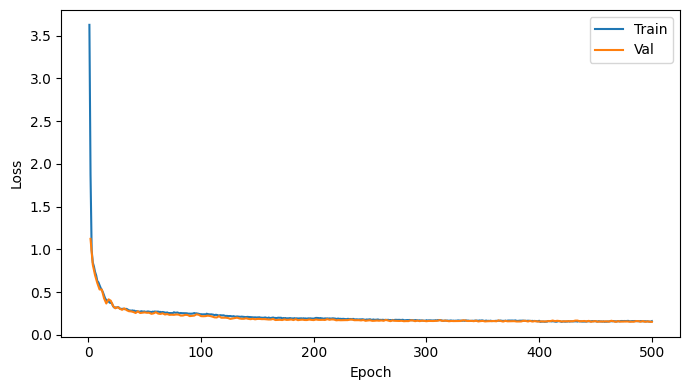

In [11]:
ep = np.array(hist["epoch"], dtype=int)
tr = np.array(hist["train_loss"], dtype=float)
va = np.array(hist["val_loss"], dtype=float)

plt.figure(figsize=(7,4))
plt.plot(ep, tr, label="Train")
if np.isfinite(va).any():
    m = np.isfinite(va)
    plt.plot(ep[m], va[m], label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#Train 

BEST_ENC_PATH  = "/kaggle/working/byol_ckpts/byol_encoder_best.pth"   # from Step 8
BEST_HEAD_PATH = "/kaggle/working/byol_ckpts/byol_linear_head_best.pth"

# ---- build the same backbone used for BYOL encoder (ResNet-50 features) ----
def build_encoder(pretrained=False):
    backbone = torchvision.models.resnet50(
        weights=None if not pretrained else torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    )
    backbone.fc = nn.Identity()   # 2048-dim features
    FEAT_DIM = 2048
    return backbone, FEAT_DIM

# ---- rebuild encoder & load BYOL-pretrained weights, then freeze ----
encoder, FEAT_DIM = build_encoder(pretrained=False)
ck = torch.load(BEST_ENC_PATH, map_location="cpu")
missing = encoder.load_state_dict(ck["online_encoder"], strict=False)
print("Encoder load (missing/unexpected):", missing)

encoder = encoder.to(DEVICE).eval()
for p in encoder.parameters():
    p.requires_grad = False

# ---- linear head ----
num_classes = int(max(train_df["label"].max(), val_df["label"].max(), test_df["label"].max()) + 1)

class LinearHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.fc(x)

head = LinearHead(FEAT_DIM, num_classes).to(DEVICE)
opt_lin = optim.Adam(head.parameters(), lr=LR_LINEAR)
crit = nn.CrossEntropyLoss()

# ---- history containers ----
lin_hist = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# ---- one epoch (train/eval) ----
def linear_epoch(encoder, loader, train=True):
    head.train(mode=train)
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        with torch.no_grad():
            feats = encoder(x)                 # [B, 2048]
        logits = head(feats)
        loss = crit(logits, y)

        if train:
            opt_lin.zero_grad(set_to_none=True)
            loss.backward()
            opt_lin.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return total_loss / max(1,total), correct / max(1,total)

# ----train linear head ----
best_val_acc = 0.0
for ep in range(1, EPOCHS_LINEAR + 1):
    tr_loss, tr_acc = linear_epoch(encoder, train_cls_loader, train=True)
    va_loss, va_acc = linear_epoch(encoder, val_cls_loader,   train=False)

    # log history
    lin_hist["epoch"].append(ep)
    lin_hist["train_loss"].append(tr_loss)
    lin_hist["train_acc"].append(tr_acc * 100.0)  # store as %
    lin_hist["val_loss"].append(va_loss)
    lin_hist["val_acc"].append(va_acc * 100.0)    # store as %

    # save best head
    if va_acc > best_val_acc + 1e-6:
        best_val_acc = va_acc
        torch.save(
            {"state_dict": head.state_dict(), "feat_dim": FEAT_DIM, "num_classes": num_classes},
            BEST_HEAD_PATH
        )
        print(f"[Linear {ep}] Saved best head -> {BEST_HEAD_PATH}")

    print(f"[Linear {ep:02d}] "
          f"train: loss={tr_loss:.4f}, acc={tr_acc*100:.2f}% | "
          f"val: loss={va_loss:.4f}, acc={va_acc*100:.2f}%")

Encoder load (missing/unexpected): <All keys matched successfully>
[Linear 1] Saved best head -> /kaggle/working/byol_ckpts/byol_linear_head_best.pth
[Linear 01] train: loss=0.3983, acc=86.38% | val: loss=0.3483, acc=88.17%
[Linear 2] Saved best head -> /kaggle/working/byol_ckpts/byol_linear_head_best.pth
[Linear 02] train: loss=0.3000, acc=89.80% | val: loss=0.3767, acc=88.28%
[Linear 3] Saved best head -> /kaggle/working/byol_ckpts/byol_linear_head_best.pth
[Linear 03] train: loss=0.2673, acc=90.98% | val: loss=0.3190, acc=89.17%
[Linear 04] train: loss=0.2555, acc=91.37% | val: loss=0.3520, acc=88.54%
[Linear 5] Saved best head -> /kaggle/working/byol_ckpts/byol_linear_head_best.pth
[Linear 05] train: loss=0.2453, acc=91.60% | val: loss=0.2792, acc=91.04%
[Linear 6] Saved best head -> /kaggle/working/byol_ckpts/byol_linear_head_best.pth
[Linear 06] train: loss=0.2370, acc=91.90% | val: loss=0.2496, acc=91.35%
[Linear 7] Saved best head -> /kaggle/working/byol_ckpts/byol_linear_head_

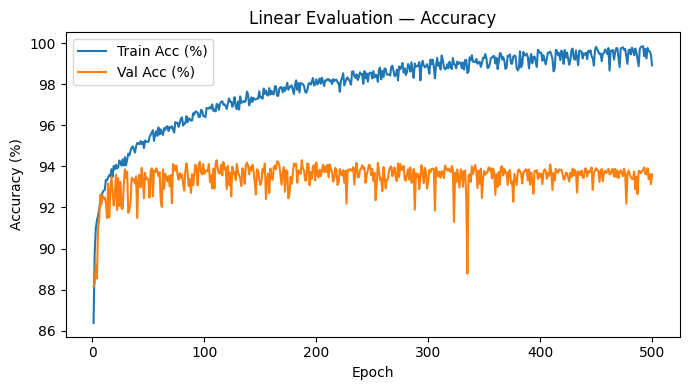

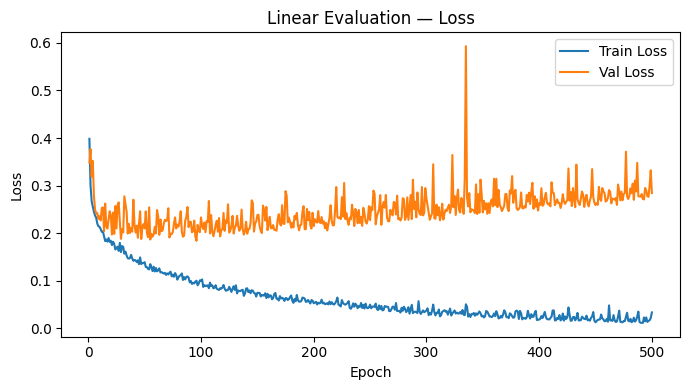

In [13]:
# --- Accuracy curve (%)
plt.figure(figsize=(7,4))
plt.plot(lin_hist["epoch"], lin_hist["train_acc"], label="Train Acc (%)")
plt.plot(lin_hist["epoch"], lin_hist["val_acc"],   label="Val Acc (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Linear Evaluation — Accuracy")
plt.legend(); 
plt.tight_layout()
plt.show()

# --- Loss curve
plt.figure(figsize=(7,4))
plt.plot(lin_hist["epoch"], lin_hist["train_loss"], label="Train Loss")
plt.plot(lin_hist["epoch"], lin_hist["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Linear Evaluation — Loss")
plt.legend(); 
plt.tight_layout()
plt.show()


In [14]:
# ---- evaluate on TEST ----
all_y, all_pred = [], []
crit = nn.CrossEntropyLoss()
test_loss, total = 0.0, 0

with torch.no_grad():
    for x, y in test_cls_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        feats = encoder(x)
        logits = head(feats)  # Use `head` instead of `lin_model`
        loss = crit(logits, y)

        pred = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        all_pred.extend(pred)
        all_y.extend(y.cpu().numpy().tolist())

        test_loss += loss.item() * x.size(0)
        total += y.size(0)

acc = accuracy_score(all_y, all_pred)
test_loss = test_loss / max(1, total)

print(f"Test Accuracy: {acc*100:.2f}%")
print(classification_report(all_y, all_pred, digits=4, zero_division=0))  #  warning fixed

Test Accuracy: 94.67%
              precision    recall  f1-score   support

           0     0.9344    0.9500    0.9421       300
           1     0.9803    0.9967    0.9884       300
           2     0.9058    0.9300    0.9178       300
           3     0.8854    0.8960    0.8907       250
           4     0.9834    0.9480    0.9654       250
           5     0.9310    0.9450    0.9380       200
           6     0.9399    0.8760    0.9068       250
           7     0.9868    0.9967    0.9917       300
           8     0.9080    0.9080    0.9080       250
           9     0.9967    0.9933    0.9950       300

    accuracy                         0.9467      2700
   macro avg     0.9452    0.9440    0.9444      2700
weighted avg     0.9469    0.9467    0.9466      2700



In [15]:
@torch.no_grad()
def extract_features(encoder, loader, device=None):
    """Freeze encoder → collect features & labels from a loader."""
    if device is None:
        device = next(encoder.parameters()).device
    encoder.eval()
    feats, labels = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        z = encoder(x)              # shape: [B, D]
        z = z.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        feats.append(z); labels.append(y)
    feats  = np.concatenate(feats, axis=0)
    labels = np.concatenate(labels, axis=0)
    return feats, labels

def silhouette_cosine(feats, labels):
    """Silhouette score with cosine distance; safe when a single class present."""
    if len(np.unique(labels)) < 2 or len(labels) < 3:
        return float("nan")
    # sklearn expects a similarity converted to distance for 'cosine'
    return silhouette_score(feats, labels, metric="cosine")

def tsne_plot_3d(feats, labels, title,
                 perplexity=30, max_points=5000, seed=42, save_html=None):
    """3D t-SNE (Plotly) — caps points, auto-safe perplexity, saves HTML if path given."""
    # cap points for speed
    if feats.shape[0] > max_points:
        idx = np.random.RandomState(seed).choice(feats.shape[0], size=max_points, replace=False)
        feats = feats[idx]; labels = labels[idx]

    # t-SNE rule: perplexity < n_samples
    n = feats.shape[0]
    perp = min(perplexity, max(5, n // 3))  # keep within a safe range

    emb = TSNE(
        n_components=3, perplexity=perp, init="pca",
        learning_rate="auto", random_state=seed, n_iter=1000, verbose=0
    ).fit_transform(feats)

    fig = px.scatter_3d(
        x=emb[:,0], y=emb[:,1], z=emb[:,2],
        color=labels.astype(str), title=title, height=700, width=900
    )
    fig.update_traces(marker=dict(size=3))
    if save_html:
        fig.write_html(save_html)
        print(f"Saved interactive HTML to: {save_html}")
    fig.show()


In [16]:
# TRAIN set clusters (frozen encoder)
train_feats, train_labels = extract_features(encoder, train_cls_loader, device=DEVICE)
print(f"Training silhouette score (cosine): {silhouette_cosine(train_feats, train_labels):.4f}")

tsne_plot_3d(
    train_feats, train_labels,
    title="3D t-SNE (train features)",
    perplexity=30, max_points=5000, seed=42,
    save_html="/kaggle/working/tsne3d_train.html"
)


Training silhouette score (cosine): 0.3359
Saved interactive HTML to: /kaggle/working/tsne3d_train.html


In [17]:
# TEST set clusters (frozen encoder)
test_feats, test_labels = extract_features(encoder, test_cls_loader, device=DEVICE)
print(f"Test silhouette score (cosine): {silhouette_cosine(test_feats, test_labels):.4f}")

tsne_plot_3d(
    test_feats, test_labels,
    title="3D t-SNE (test features)",
    perplexity=30, max_points=5000, seed=42,
    save_html="/kaggle/working/tsne3d_test.html"
)


Test silhouette score (cosine): 0.3564
Saved interactive HTML to: /kaggle/working/tsne3d_test.html
